## Installing the requirements

Install all the required packages by running `pip install -r ghosh_subhodeep_req.txt` 

## Making the necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import auc

In [3]:
import tensorflow as tf

In [95]:
from tf_keras.models import Sequential
from tf_keras.layers import LSTM, Dense

## Fetch the dataset

#### Fetching the dataset from 'https://archive.ics.uci.edu/dataset/73/mushroom' and also spreading the dataset into features and targets

In [275]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
mushroom.data.features.to_csv("ghosh_subhodeep_mushroom_features.csv", index=False)
mushroom.data.targets.to_csv("ghosh_subhodeep_mushroom_labels.csv", index=False)

User may select the fraction of the dataset they want to perform all the computations on. Original dataset has 8124 instances.
<br>I am using 40% of the dataset to make the computations fast.

In [276]:
# User may select a fraction of the dataset to perform all these computations on, eg: 0.5 X (# of rows in dataset)
amount_of_data = float(input("Enter the amount of data (as a fraction) that you want to perform upon: "))
amount_of_data = amount_of_data if 0.1 < amount_of_data <= 1 else 1

# data (as pandas dataframes) 
features = pd.read_csv("ghosh_subhodeep_mushroom_features.csv") 
labels = pd.read_csv("ghosh_subhodeep_mushroom_labels.csv") 
features = features.sample(frac=amount_of_data, random_state=42)
labels = labels.loc[features.index]
features.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

## Analyse and Pre-process the dataset

### Looking at the type of features and target values of the dataset

There are 22 feature for this dataset, each describing the physical characteristics of a given mushroom. Every row is thus the entire physical characteristics of a particular mushroom. 
<br>Some important details about the values for each feature and what they indicate: 
><br>    1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
<br>     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
<br>     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
<br>     4. bruises:                  bruises=t,no=f
<br>     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
<br>     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
<br>     7. gill-spacing:             close=c,crowded=w,distant=d
<br>     8. gill-size:                broad=b,narrow=n
<br>     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
<br>    10. stalk-shape:              enlarging=e,tapering=t
<br>    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=NaN
<br>    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
<br>    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
<br>    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
<br>    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
<br>    16. veil-type:                partial=p,universal=u
<br>    17. veil-color:               brown=n,orange=o,white=w,yellow=y
<br>    18. ring-number:              none=n,one=o,two=t
<br>    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
<br>    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
<br>    21. population:               abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
<br>    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [277]:
features.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,f,f,n,f,n,f,w,b,h,t,...,f,w,w,p,w,o,e,n,s,g
1,f,s,e,f,y,f,c,n,b,t,...,s,p,p,p,w,o,e,w,v,l
2,x,y,n,f,f,f,c,n,b,t,...,s,w,p,p,w,o,e,w,v,l
3,f,y,g,t,n,f,c,b,n,t,...,s,g,p,p,w,o,p,n,y,d
4,f,s,e,f,s,f,c,n,b,t,...,s,p,p,p,w,o,e,w,v,l


In [278]:
# Describe the features 
features.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,3250,3250,3250,3250,3250,3250,3250,3250,3250,3250,...,3250,3250,3250,3250,3250,3250,3250,3250,3250,3250
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,w,w,p,w,o,p,w,v,d
freq,1463,1326,894,1905,1387,3169,2726,2245,679,1806,...,1948,1799,1738,3250,3172,3001,1587,939,1602,1244


#### Dropping features that contribute no information

We notice that the feature "veil-type" has only one value throughout the dataset. Hence it conveys no information about the dataset. Thus it is a candidate to be dropped - thus feature reduction.

In [279]:
# Run this cell once to drop the "veil-type" feature
features.drop("veil-type", axis=1, inplace=True)

We observe the number of features has indeed reduced to 21 as the "veil-type" feature has been dropped.

In [280]:
features.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,3250,3250,3250,3250,3250,3250,3250,3250,3250,3250,...,3250,3250,3250,3250,3250,3250,3250,3250,3250,3250
unique,6,4,10,2,9,2,2,2,12,2,...,4,4,9,9,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,s,w,w,w,o,p,w,v,d
freq,1463,1326,894,1905,1387,3169,2726,2245,679,1806,...,2069,1948,1799,1738,3172,3001,1587,939,1602,1244


#### Handling missing values

We see from the following output that only one feature, "stalk-root" has missing values. We need to handle that. The best option is to fill the missing
values with the mode value of the column, i.e., the most frequently occuring value.

In [281]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 3250 non-null   object
 1   cap-surface               3250 non-null   object
 2   cap-color                 3250 non-null   object
 3   bruises                   3250 non-null   object
 4   odor                      3250 non-null   object
 5   gill-attachment           3250 non-null   object
 6   gill-spacing              3250 non-null   object
 7   gill-size                 3250 non-null   object
 8   gill-color                3250 non-null   object
 9   stalk-shape               3250 non-null   object
 10  stalk-root                2267 non-null   object
 11  stalk-surface-above-ring  3250 non-null   object
 12  stalk-surface-below-ring  3250 non-null   object
 13  stalk-color-above-ring    3250 non-null   object
 14  stalk-color-below-ring  

We observe the mode for the "stalk-root" feature is "b" ("bulbous"). Thus we take it for filling the missing values.

In [282]:
features["stalk-root"].value_counts()
features["stalk-root"].isna().sum()

np.int64(983)

In [283]:
def impute_missing_values(features):
    # Replace the NaN values with the mode value
    features["stalk-root"].fillna(features["stalk-root"].mode()[0], inplace=True)
    return features

features = impute_missing_values(features)
print(features["stalk-root"].value_counts())
print(features["stalk-root"].isna().sum())

stalk-root
b    2479
e     460
c     229
r      82
Name: count, dtype: int64
0


#### Understanding the target 
Edible = e, Poisonous = p
Our target is to predict a mushroom is edible or not. In that sense, edible = positive outcome, poisonous = negative outcome

We only need one target for our project which is "Machine failure". It comprises of all the other types of failure such TWF, HDF and so on. So we will drop the other target columns and just keep "Machine failure" as our only target.

In [284]:
labels.head()

,poisonous
0,e
1,p
2,p
3,e
4,p


In [285]:
# Describe the target
labels.describe()

,poisonous
count,3250
unique,2
top,e
freq,1678


#### Categorical to numerical

As we can clearly observe, all the features and the target for the mushroom dataset is categorical. Thus we need to convert them into numerical for our ML and DL models to be able to work on them

In [286]:
def obj_to_cat(df):
    # Convert object dtype to categorical
    cols = df.select_dtypes(['object']).columns
    for col in cols:
        df[col] = df[col].astype('category')
    # Change the categorical values to numerical
    df[cols] = df[cols].apply(lambda x: x.cat.codes)
    return df
features = obj_to_cat(features)
labels = obj_to_cat(labels)
print("Features table converted to numerical values: \n", features.head())
print("\nLabels table converted to numerical values: \n",labels.head())

Features table converted to numerical values: 
    cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0          2            0          4        0     5                1   
1          2            2          2        0     8                1   
2          5            3          4        0     2                1   
3          2            3          3        1     5                1   
4          2            2          2        0     7                1   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0             1          0           3            1  ...   
1             0          1           0            1  ...   
2             0          1           0            1  ...   
3             0          0           5            1  ...   
4             0          1           0            1  ...   

   stalk-surface-above-ring  stalk-surface-below-ring  stalk-color-above-ring  \
0                         2                         0                       7

### Visualizing the data

We observe that our data is barely imbalanced (difference is less than 5%). Thus we can have a normal KFold cross validation instead of Stratified KFold cross validation which ensures a similar percentage of labels for both the classes in the train-test split.

We observe that our data is completely imbalanced (difference between classes is higher than 90%). Thus we need to do Stratified samping and apply Stratified KFold cross validation which ensures a similar percentage of labels for both the classes in the train-test split.

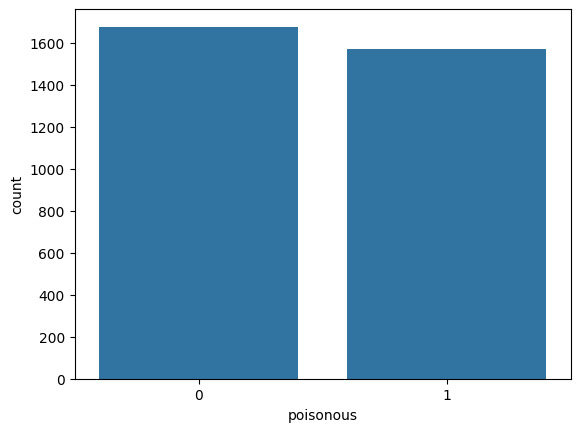

poisonous
0            1678
1            1572
Name: count, dtype: int64
----------Checking for Data Imbalance------------
Number of Positive Outcomes:  1678
Percentage of Positive Outcomes: 51.63%
Number of Negative Outcomes :  1572
Percentage of Negative Outcomes: 48.37%




In [287]:
# Visualizing the distribution of the target variable
sns.countplot(x="poisonous", data=labels)
plt.show()

# Checking the dataset for data imbalance
print(labels.value_counts())
positive_outcomes, negative_outcomes = labels.value_counts()
total_samples = labels.count()
print('----------Checking for Data Imbalance------------')
print('Number of Positive Outcomes: ', positive_outcomes)
print('Percentage of Positive Outcomes: {}%'.format(round((positive_outcomes/total_samples[0]) * 100, 2)))
print('Number of Negative Outcomes : ', negative_outcomes)
print('Percentage of Negative Outcomes: {}%'.format(round((negative_outcomes/total_samples[0]) * 100, 2)))
print('\n')

#### Checking for correlation between attributes


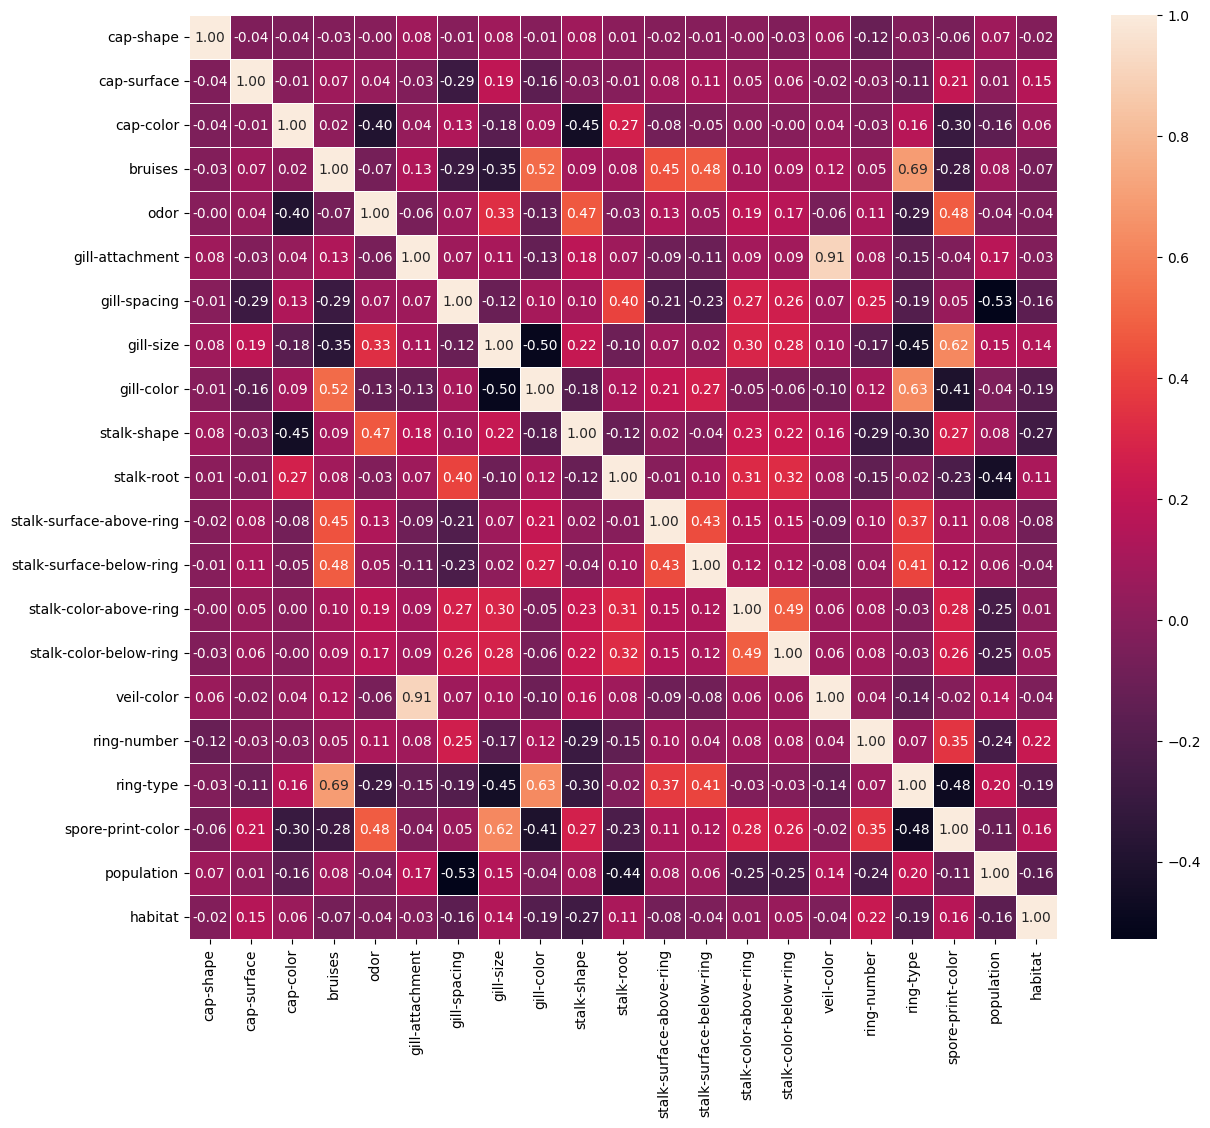

In [288]:
# Creating a correlation matrix and displaying it using a heatmap
fig, axis = plt.subplots(figsize=(14, 12))
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2f', ax=axis)
plt.show()

Closer inspection reveals that the following features have relatively high correlation:

In [289]:
threshold = 0.5
def extract_high_low_corr_fts(corr_matrix):    
    # Extract the upper triangle of the correlation matrix to avoid duplicate pairs
    corr_pairs = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(bool))
    # Filter out correlation values based on the absolute threshold
    filtered_pairs = corr_pairs[(corr_pairs > threshold) | (corr_pairs < -threshold)].stack().reset_index()
    filtered_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    # Drop the feature pairs that are the same features
    filtered_pairs = filtered_pairs[filtered_pairs["Feature1"] != filtered_pairs["Feature2"]].reset_index(drop=True)
        
    return filtered_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

print("Pairs of features with relatively high correlation (>0.5 or <-0.5) are as follows: \n", extract_high_low_corr_fts(correlation_matrix))

Pairs of features with relatively high correlation (>0.5 or <-0.5) are as follows: 
             Feature1         Feature2  Correlation
0         veil-color  gill-attachment     0.909093
1          ring-type          bruises     0.694422
2          ring-type       gill-color     0.629371
3  spore-print-color        gill-size     0.620226
4         gill-color          bruises     0.522847
5         gill-color        gill-size    -0.503799
6         population     gill-spacing    -0.528222


Apart from "veil-color" and "gill-atttachment" and "ring-type" and "bruises" with a correlation of ~0.9 and ~0.7, other features do not really have a high correlation. Only 6 pairs of features have correlation higher than 50%. Hence, the dataset can be confidently utilized for our project.

Since "veil-color" and "gill-atttachment" have such high correlation, we can drop one of them. We can also drop "bruises" and "gill-color" since they have a high correlation with "ring-type". This will reduce the number of features and get rid of dependent features.

In [290]:
# Run this cell once to drop the "veil-color", "bruises" and "gill-color" features
features.drop("veil-color", axis=1, inplace=True)
features.drop("bruises", axis=1, inplace=True)
features.drop("gill-color", axis=1, inplace=True)
features.describe()

,cap-shape,cap-surface,cap-color,odor,gill-attachment,gill-spacing,gill-size,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
count,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000,3250.000000
mean,3.336308,1.851077,4.535385,4.133538,0.975077,0.161231,0.309231,0.555692,0.429231,1.573538,1.596923,5.815692,5.782769,1.069846,2.299692,3.561538,3.637846,1.528308
std,1.616647,1.224546,2.554812,2.114311,0.155915,0.367800,0.462248,0.496965,0.824416,0.620994,0.679464,1.913375,1.902893,0.267879,1.794978,2.385074,1.245583,1.728395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6.000000,6.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,3.000000,2.000000,4.000000,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,7.000000,7.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,5.000000,3.000000,8.000000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,7.000000,7.000000,1.000000,4.000000,7.000000,4.000000,3.000000
max,5.000000,3.000000,9.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,8.000000,8.000000,2.000000,4.000000,8.000000,5.000000,6.000000


In [297]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cap-shape                 3250 non-null   int8 
 1   cap-surface               3250 non-null   int8 
 2   cap-color                 3250 non-null   int8 
 3   odor                      3250 non-null   int8 
 4   gill-attachment           3250 non-null   int8 
 5   gill-spacing              3250 non-null   int8 
 6   gill-size                 3250 non-null   int8 
 7   stalk-shape               3250 non-null   int8 
 8   stalk-root                3250 non-null   int8 
 9   stalk-surface-above-ring  3250 non-null   int8 
 10  stalk-surface-below-ring  3250 non-null   int8 
 11  stalk-color-above-ring    3250 non-null   int8 
 12  stalk-color-below-ring    3250 non-null   int8 
 13  ring-number               3250 non-null   int8 
 14  ring-type                 3250 non-null 

#### Visualize the distribution of values for each attribute by plotting histograms

It is interesting to observe from the following histograms, the distribution of most attributes are not skewed except for "stalk-color-above-ring", "stalk-root", "stalk-color-below-ring", "population" and "habitat". "stalk-color-above-ring" and "stalk-color-below-ring" also display a high degree of symmetry.

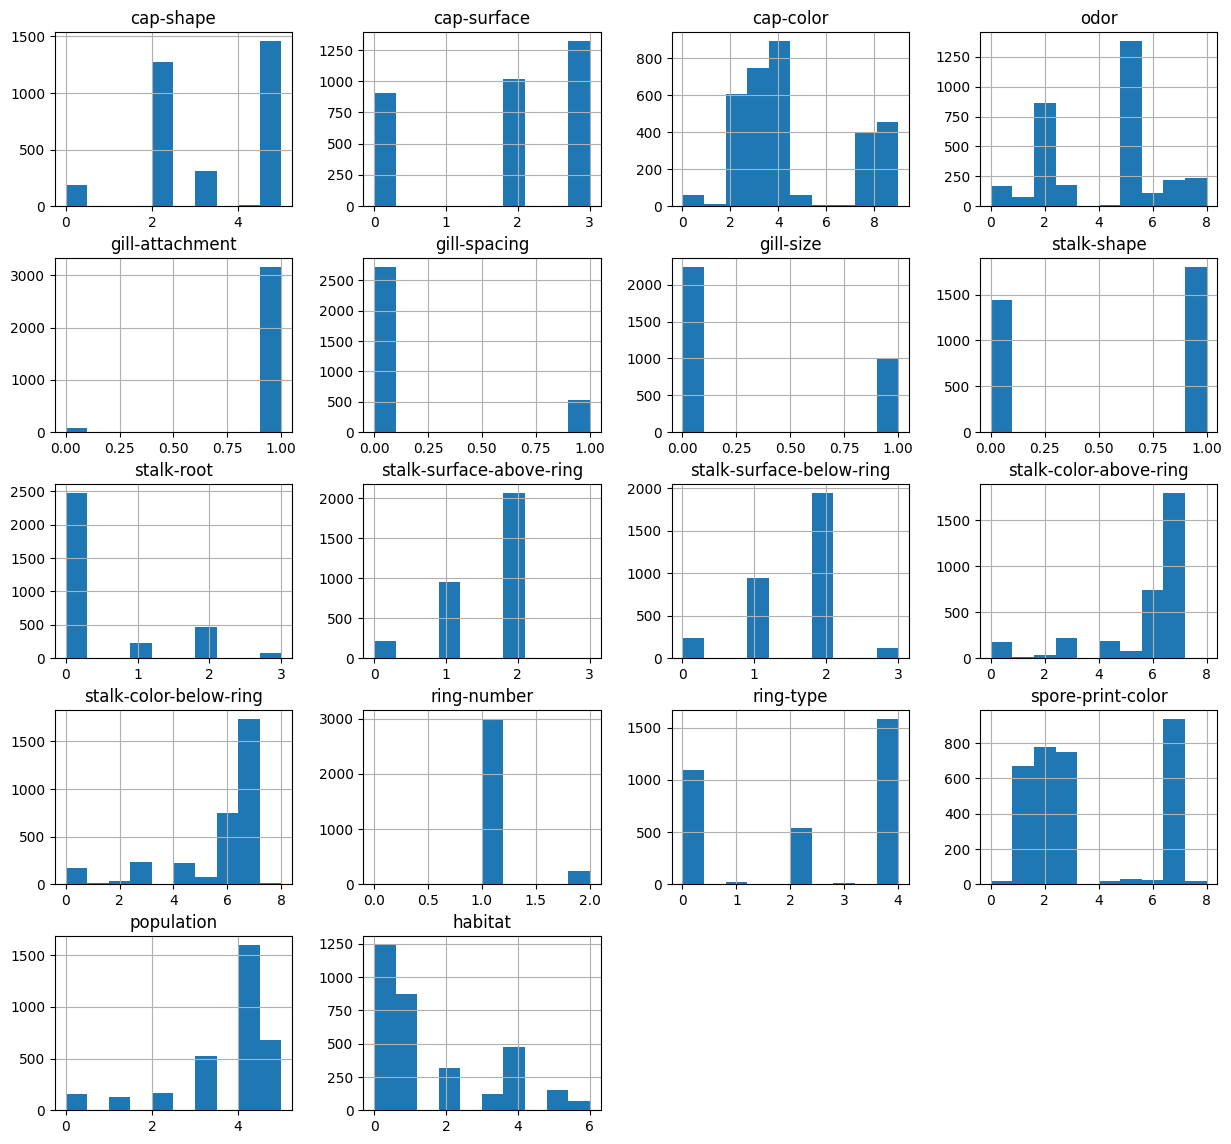

In [291]:
features.hist(figsize=(15, 14))
plt.show()

#### Generate a pairplot to visualize multiple pairwise bivariate distributions within our dataset

(The next cell takes a lot of time to execute since there are 18x18 pair plots to generate. DO NOT RUN IT if you cannot allow it to complete its execution, otherwise kernel restart might be required)

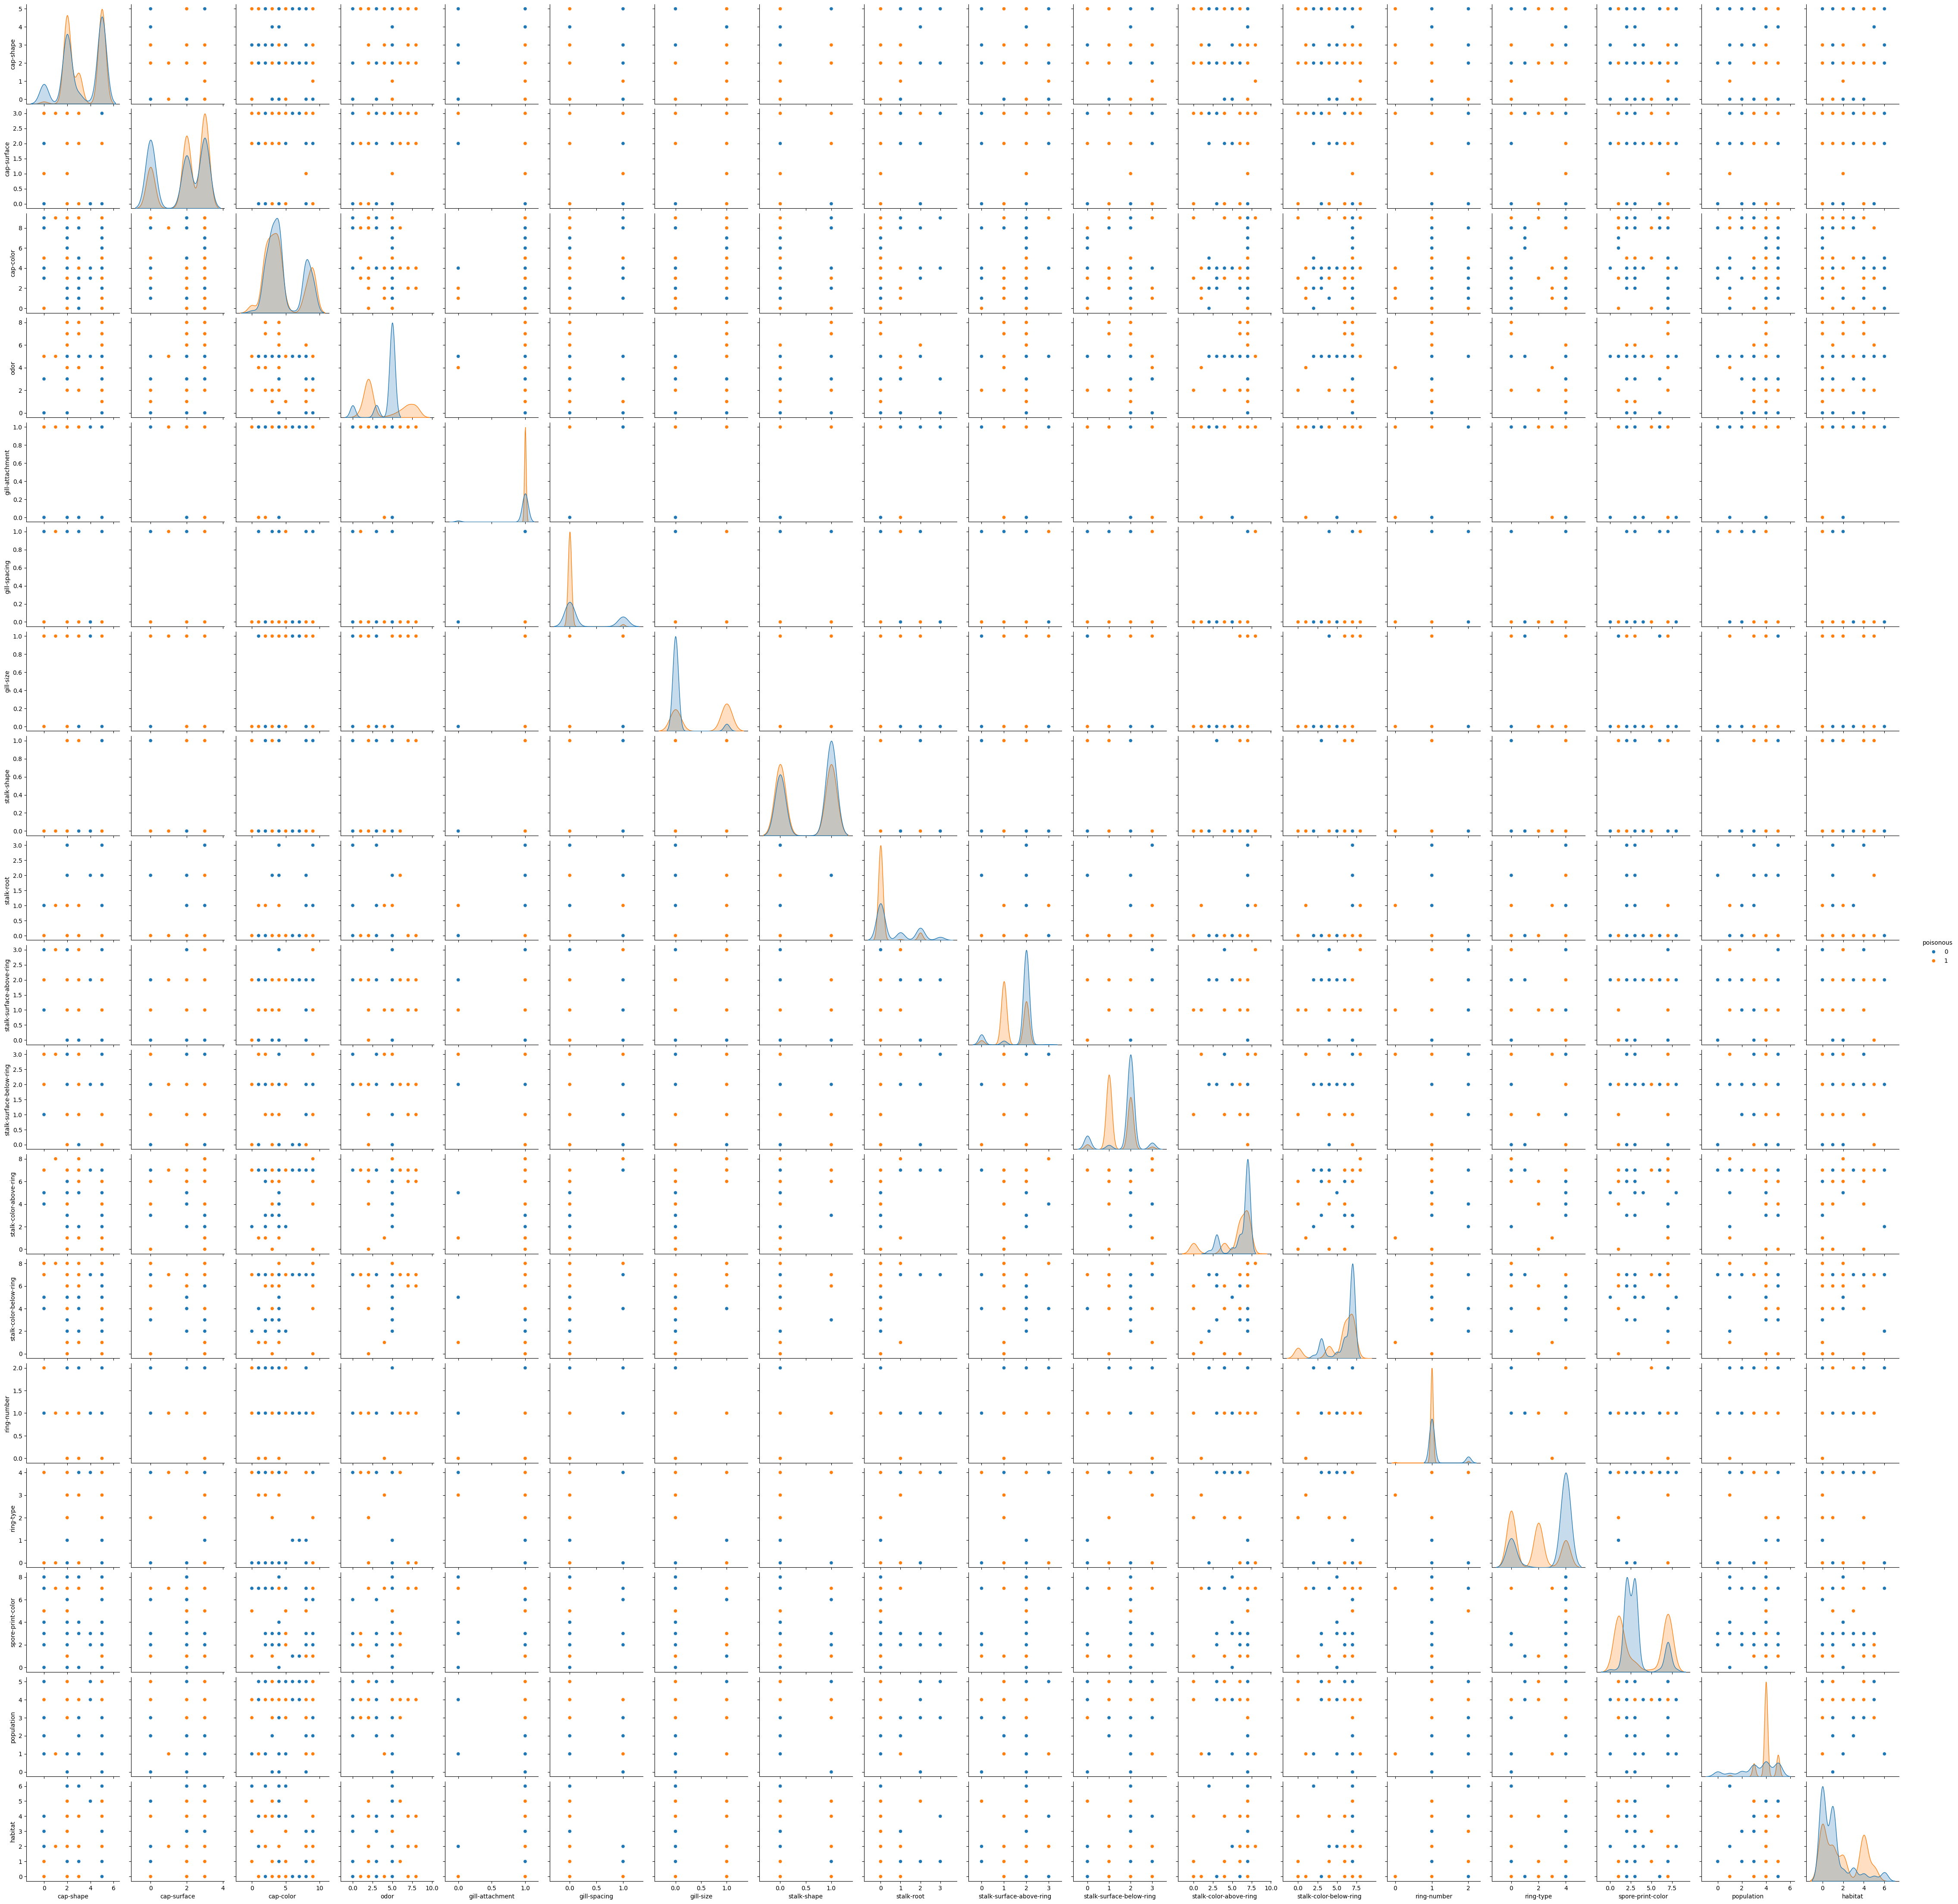

In [184]:
dataset = features.copy()
dataset["poisonous"] = labels
# Creating a pair plot with a hue based on the 'poisonous' feature
sns.pairplot(dataset, hue='poisonous')
plt.show()

### Train Test Data Split

In [292]:
# Perform train-test split with a 10% test size
features_train_all, features_test_all, labels_train_all, labels_test_all = train_test_split(features, labels, test_size=0.2, random_state=42)
# Reset indices for the training and testing sets
for dataset in [features_train_all, features_test_all, labels_train_all, labels_test_all]:
    dataset.reset_index(drop=True, inplace=True)

#### Normalization or Standard Scaling
We do not require normalization or standard scaling for this dataset since all the features were initially categorical and have been coded to discrete numerical values that are not very large.

### Define the necessary function for model fitting and metric calculation

In [293]:
# A function to calculate all the metrics using the confusion matrix
def calc_metrics(confusion_matrix):
        TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
        FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        FPR = FP / (TN + FP)
        FNR = FN / (TP + FN)
        FDR = FP / (FP + TP)
        NPV = TN / (TN + FN)
        Precision = TP / (TP + FP)
        F1_measure = 2 * TP / (2 * TP + FP + FN)
        Accuracy = (TP + TN) / (TP + FP + FN + TN)
        Error_rate = (FP + FN) / (TP + FP + FN + TN)
        BACC = (TPR + TNR) / 2
        TSS = TPR - FPR
        HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
        metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, FDR, NPV, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]
        return metrics

To note here, LSTM expects input data in the shape (# of datapoints, pack size, # of features). But our dataset is in the shape (# of datapoints, # of features). Therefore, we consider the pack_size to be equal to # of features and # of features is considered as 1. What this does is, the LSTM sequentially uses the features to predict the label similar to how in time-series it uses a sequence of values for previous timestamps to predict the current value.

In [298]:
def get_metrics(model, ft_train, ft_test, lb_train, lb_test, LSTM_flag):

    metrics = []

    # Convert data to numpy array
    Xtrain, Xtest, ytrain, ytest = map(np.array, [ft_train, ft_test, lb_train, lb_test])

    if LSTM_flag == 1: # when model is LSTM

        # Reshape data
        shape = Xtrain.shape
        # shape: (#_of_datapoints, #_of_features) -> (#_of_datapoints, #_of_features, 1)
        Xtrain_reshaped = Xtrain.reshape(len(Xtrain), shape[1], 1)  
        Xtest_reshaped = Xtest.reshape(len(Xtest), shape[1], 1)

        model.fit(Xtrain_reshaped, ytrain, epochs=50, validation_data=(Xtest_reshaped, ytest), verbose=0)
        lstm_scores = model.evaluate(Xtest_reshaped, ytest, verbose=0)
        predict_prob = model.predict(Xtest_reshaped)
        pred_labels = predict_prob > 0.5
        pred_labels_1 = pred_labels.astype(int)

        # Compute the confusion_matrix, brier_score and roc_auc using library function and get the other metrics using calc_metrics() function
        matrix = confusion_matrix(ytest, pred_labels_1, labels=[1, 0])
        lstm_brier_score = brier_score_loss(ytest, predict_prob)
        lstm_roc_auc = roc_auc_score(ytest, predict_prob)
        metrics.extend(calc_metrics(matrix))
        metrics.extend([lstm_brier_score, lstm_roc_auc, lstm_scores[1]])

    elif LSTM_flag == 0: # when model is not LSTM

        model.fit(Xtrain, ytrain)
        predicted = model.predict(Xtest)

        # Compute the confusion_matrix, brier_score and roc_auc using library function and get the other metrics using calc_metrics() function
        matrix = confusion_matrix(ytest, predicted, labels=[1, 0])
        model_brier_score = brier_score_loss(ytest, model.predict_proba(Xtest)[:, 1])
        model_roc_auc = roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1])
        metrics.extend(calc_metrics(matrix))
        metrics.extend([model_brier_score, model_roc_auc, model.score(Xtest, ytest)])

    return metrics



## Selecting the Classification Algorithms

#### I have selected the following 2 ML algorithms:
>1. Support Vector Classifier (SVC)
>2. Random Forest (RF)
<br>I chose RF as it is an ensemble learner which perfectly handles the bias-variance tradeoff and provides a model that does well both in train and test data.
SVCs can accurately seperate classes even in complex and noisy data.

#### And 1 DL algorithm:
>1. Long Short-Term Memory (LSTM)
<br>LSTM are useful when a sequence of values is used to predict the target variable. In our case, the sequence of features may or may not have some relationship between them which the LSTM learns to finally predict the target class. For example, the sequence of physical properties of a mushroom such as its stalk color, stalk shape and ring shape can be used to predict whether it is edible or poisonous. Thus we treat each feature as a timestep, allowing the LSTM to learn relationships between these features over the sequence.

### Comparing the classifiers with selected parameters by using 10-Fold Cross-Validation to calculate all metrics

Implementing 10-Fold Stratified Cross-Validation: We will be using the training data set for validation as well using 10-Fold Cross Validation
<br>(The next cell takes about 4 mins to execute.)

In [301]:
# Define K-Fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize metric columns
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR','FDR','NPV','Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS','Brier_score',
'AUC', 'Acc_by_package_fn']

# Initialize metrics lists for each algorithm
knn_metrics_list, rf_metrics_list, svm_metrics_list, lstm_metrics_list = [], [], [], []
C = 1.0

# 10 Iterations of 10-fold cross-validation
for iter_num, (train_index, test_index) in enumerate(cv.split(features_train_all, labels_train_all), start=1):

    # Initializing Random Forest Model using the best hyperparameters
    rf_model = RandomForestClassifier(max_depth=3, n_estimators=20)

    # Initializing SVM Classifier Model using the best hyperparameters
    svm_model = SVC(C=C, kernel="linear", probability=True)

    # Build the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(16, activation='relu', batch_input_shape=(None, 18, 1),return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    # Compile the LSTM model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    # Split data into training and testing sets
    features_train, features_test = features_train_all.iloc[train_index, :], features_train_all.iloc[test_index, :]
    labels_train, labels_test = labels_train_all.iloc[train_index, :], labels_train_all.iloc[test_index,:]
    
    # Get metrics for each algorithm
    rf_metrics = get_metrics(rf_model, features_train, features_test,labels_train, labels_test, 0)
    svm_metrics = get_metrics(svm_model, features_train, features_test,labels_train, labels_test, 0)
    lstm_metrics = get_metrics(lstm_model, features_train, features_test,labels_train, labels_test, 1)

    # Append metrics to respective lists
    svm_metrics_list.append(svm_metrics)
    rf_metrics_list.append(rf_metrics)
    lstm_metrics_list.append(lstm_metrics)
    # Create a DataFrame for all metrics
    metrics_all_df = pd.DataFrame([svm_metrics,rf_metrics,lstm_metrics],columns=metric_columns, index=['SVM','RF','LSTM'])
    # Display metrics for all algorithms in each iteration
    print('\nIteration {}: \n'.format(iter_num))
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(iter_num))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')

9/9 [==============================] - 0s 1ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                      SVM      RF    LSTM
TP                 109.00  109.00  112.00
TN                 137.00  144.00  140.00
FP                  11.00    4.00    8.00
FN                   3.00    3.00    0.00
TPR                  0.97    0.97    1.00
TNR                  0.93    0.97    0.95
FPR                  0.07    0.03    0.05
FNR                  0.03    0.03    0.00
FDR                  0.09    0.04    0.07
NPV                  0.98    0.98    1.00
Precision            0.91    0.96    0.93
F1_measure           0.94    0.97    0.97
Accuracy             0.95    0.97    0.97
Error_rate           0.05    0.03    0.03
BACC                 0.95    0.97    0.97
TSS                  0.90    0.95    0.95
HSS                  0.89    0.95    0.94
Brier_score          0.05    0.03    0.02
AUC                  0.97    1.00    1.00
Acc_by_package_fn    0.95    0.97    

In [ ]:
# Initialize metric index for each iteration
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5', 'iter6','iter7', 'iter8', 'iter9', 'iter10']
algorithms = ['SVM','RF','LSTM']
# Create DataFrames for each algorithm's metrics
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns,index=metric_index_df)
svm_metrics_df = pd.DataFrame(svm_metrics_list, columns=metric_columns,index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns,index=metric_index_df)
# Display metrics for each algorithm in each iteration
for i, metrics_df in enumerate([svm_metrics_df, rf_metrics_df, lstm_metrics_df], start=1):
    print(f'\nMetrics for Algorithm {algorithms[i-1]}:\n')
    print(metrics_df.round(decimals=2).T)
    print('\n')


Metrics for Algorithm SVM:

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7  \
TP                 109.00  125.00  140.00  139.00  114.00  119.00  110.00   
TN                 137.00  119.00  105.00  111.00  135.00  129.00  135.00   
FP                  11.00    8.00    7.00    7.00    5.00    2.00    6.00   
FN                   3.00    8.00    8.00    3.00    6.00   10.00    9.00   
TPR                  0.97    0.94    0.95    0.98    0.95    0.92    0.92   
TNR                  0.93    0.94    0.94    0.94    0.96    0.98    0.96   
FPR                  0.07    0.06    0.06    0.06    0.04    0.02    0.04   
FNR                  0.03    0.06    0.05    0.02    0.05    0.08    0.08   
FDR                  0.09    0.06    0.05    0.05    0.04    0.02    0.05   
NPV                  0.98    0.94    0.93    0.97    0.96    0.93    0.94   
Precision            0.91    0.94    0.95    0.95    0.96    0.98    0.95   
F1_measure           0.94    0.94    0.95    0.

In [303]:
# Calculate the average metrics for each algorithm
rf_avg_df = rf_metrics_df.mean()
svm_avg_df = svm_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()
# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame({'SVM':svm_avg_df, 'RF': rf_avg_df, 'LSTM': lstm_avg_df}, index=metric_columns)
# Display the average performance for each algorithm
print(avg_performance_df.round(decimals=2))
print('\n')

                      SVM      RF    LSTM
TP                 117.50  120.50  122.10
TN                 129.00  133.00  134.10
FP                   6.40    2.40    1.30
FN                   7.10    4.10    2.50
TPR                  0.94    0.97    0.98
TNR                  0.95    0.98    0.99
FPR                  0.05    0.02    0.01
FNR                  0.06    0.03    0.02
FDR                  0.05    0.02    0.01
NPV                  0.95    0.97    0.98
Precision            0.95    0.98    0.99
F1_measure           0.94    0.97    0.98
Accuracy             0.95    0.98    0.99
Error_rate           0.05    0.02    0.01
BACC                 0.95    0.97    0.99
TSS                  0.89    0.95    0.97
HSS                  0.89    0.95    0.97
Brier_score          0.05    0.03    0.01
AUC                  0.97    1.00    1.00
Acc_by_package_fn    0.95    0.98    0.99




#### Evaluating the performance of various algorithms by comparing their ROC curves and AUC scores on the test dataset.

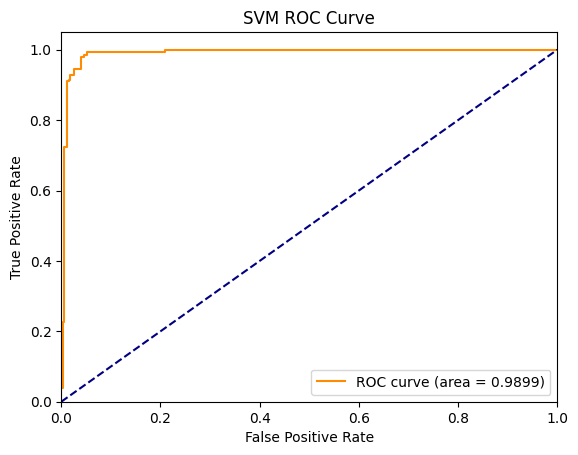

In [314]:
# SVM Classifier Model
svm_model = SVC(C=C, kernel='linear', probability=True)
svm_model.fit(features_train_all, labels_train_all)
# Obtain predicted probabilities
y_score_svm = svm_model.predict_proba(features_test_all)[:, 1]
# Compute ROC curve and ROC area
fpr_svm, tpr_svm, _ = roc_curve(labels_test_all, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
# Plot SVM ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color="darkorange", label="ROC curve (area = {:.4f})".format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend(loc="lower right")
plt.show()

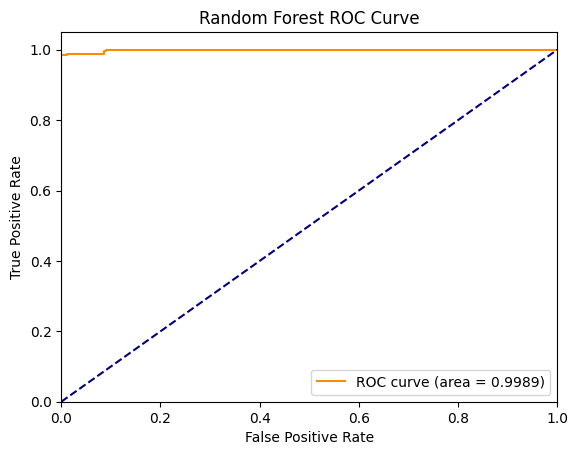

In [315]:
# Random Forest Model
rf_model = RandomForestClassifier(max_depth=4,n_estimators=20)
rf_model.fit(features_train_all, labels_train_all)
# Obtain predicted probabilities
y_score_rf = rf_model.predict_proba(features_test_all)[:, 1]
# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(labels_test_all, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot Random Forest ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="ROC curve (area = {:.4f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

21/21 [==============================] - 0s 1ms/step


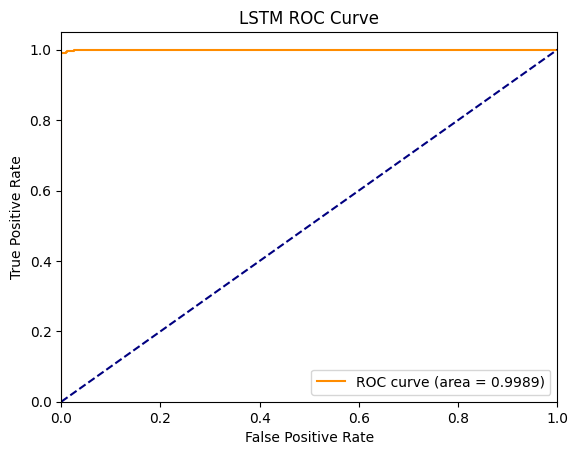

In [316]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(16, activation='relu', batch_input_shape=(None, 18, 1),return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))
# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# Convert data to numpy array
X_train_array = features_train_all.to_numpy()
X_test_array = features_test_all.to_numpy()
y_train_array = labels_train_all.to_numpy()
y_test_array = labels_test_all.to_numpy()
# Reshape data
input_shape = X_train_array.shape
input_train = X_train_array.reshape(len(X_train_array), input_shape[1], 1)
input_test = X_test_array.reshape(len(X_test_array), input_shape[1], 1)
output_train = y_train_array
output_test = y_test_array
# Train the LSTM model
lstm_model.fit(input_train, output_train, epochs=50,validation_data=(input_test, output_test), verbose=0)
# Predict probabilities for the test set
predict_lstm = lstm_model.predict(input_test)
# Compute ROC curve and ROC area
fpr_lstm, tpr_lstm, _ = roc_curve(labels_test_all, predict_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
# Plot LSTM ROC curve
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color="darkorange", label="ROC curve (area = {:.4f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(F"LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Comparing all models

From the confusion matrix we obtain the TP, TN, FP, FN scores for all the 3 models using 10-fold cross validation. We then computed the other metrics such as TPR, TNR, FPR, FNR, etc. using them. Then we display the average of all the 10 iterations for the 3 models. 
- Our prediction deals with whether a mushroom is edible (positive class) or poisonous (negative class). Thus it is more crucial that the models do not wrongly predict the negative labels. As such False Positive is much more harmful than False Negatives since False Positives indicate that a mushroom is actually edible when it is not. LSTM performs the best in this regard, closely followed by RF which is followed by SVM. We also observe the False Positive Rate (FPR) is lowest for LSTM accordingly. Precision is also very high for LSTM as it is a measure of how many of the positive labels predicted by the model is actually positive which is a crucial measure for our dataset. We also see the False Discovery Rate (FDR), which is a measure of how many of the predicted positive labels is not positive actually, which is again the lowest for the LSTM and closely followed by RF as they have very few misclassified negative classes as indicated by their FP scores.
- We see the LSTM is the best when it comes to minimizing the False negative predictions. Consequently, its recall is highest which is a measure of how many of the positive classes was actually predicted correctly by the model. It is not the most crucial metric because even if we misclassify some of the edible mushrooms as poisonous, it won't be a dangerous mistake. 
- The TSS value indicates how perfectly a model predicts the output class, as a result higher value means it is making better predictions than the others. Hence, LSTM with a TSS OF 0.97 predicts correctly most of the time comapred to RF with a TSS of 0.95 and SVM with a much lower 0.89. It is better than accuracy in the sense that it is independent of class imbalance (which is not the case in our dataset though) and it makes balanced evaluation as it considers both FP and FN.
- AUC score measures the area under curve for ROC which is essentially the graph of TPR vs FPR. It is relevant for our dataset in the sense that it indicates the predictive power of the models on the dataset. Thus LSTM and RF are near perfect classifiers since they have a approx AUC score of 1.0 compared to SVM that still does some error in classifying but not very bad.


In [321]:
print(avg_performance_df.round(decimals=2))
print('\n')

                      SVM      RF    LSTM
TP                 117.50  120.50  122.10
TN                 129.00  133.00  134.10
FP                   6.40    2.40    1.30
FN                   7.10    4.10    2.50
TPR                  0.94    0.97    0.98
TNR                  0.95    0.98    0.99
FPR                  0.05    0.02    0.01
FNR                  0.06    0.03    0.02
FDR                  0.05    0.02    0.01
NPV                  0.95    0.97    0.98
Precision            0.95    0.98    0.99
F1_measure           0.94    0.97    0.98
Accuracy             0.95    0.98    0.99
Error_rate           0.05    0.02    0.01
BACC                 0.95    0.97    0.99
TSS                  0.89    0.95    0.97
HSS                  0.89    0.95    0.97
Brier_score          0.05    0.03    0.01
AUC                  0.97    1.00    1.00
Acc_by_package_fn    0.95    0.98    0.99




## Conclusion

In conclusion we can say that LSTM is the best model for our dataset, very closely followed by RF. This is because, the way the input is provided to the LSTM, allows it to learn the relationship between features of the dataset, which is essentially the physical properties of the mushrooms, to make the prediction of whether it is edible or not. Thus instead of predicting the label based on the features only, it also understands how the features relate to each other and thus forms an overall structure of the mushrooms that can be classified as edible or not.
Random Forest on the other hand is an ensemble learning model, it uses several bagged decision trees with randomly selected features to predict the class of the given mushroom. It does not overfit to the training data due to bagging and has a built-in capacity to do feature selection because of how trees are computed based on gini impurity. Its particularly good when decision boundaries between classes are complex.
Support Vector Machine does fairly well but not as good as LSTM or RF. This can be mitigated if we use "rbf" kernel instead of "linear" kernel as that allows the decision boundary to be non-linear. 
To note here, we have used only 40% of the original dataset to train these models (in interest of execution time). If we use the full dataset, the missclassification rate goes down even further for all the 3 models. LSTM and RF become near perfect predictors. 